In [17]:
import argparse
import subprocess, os
from process_data import *
import random
import numpy as np
import torch
from data.dataset import create_datasets
from Generator.Generator import generator
import yaml
import matplotlib.pyplot as plt
from ast import literal_eval

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
stream=open("Configs/SST-2/VAE.yaml", "r")
argsdict=yaml.safe_load(stream)
if argsdict['computer'] == 'home':
    argsdict['path'] = "/media/frederic/VAETI"
elif argsdict['computer'] == 'labo':
    argsdict['path'] = "/u/piedboef/Documents/VAETI"

if argsdict['dataset'] == "SST2":
    categories = ["neg", "pos"]
elif argsdict['dataset'] == "TREC6":
    categories = ["ABBR", "DESC", "ENTY", "HUM", "LOC", "NUM"]
elif argsdict['dataset'] == "FakeNews":
    categories = ["Fake", "Real"]
elif argsdict['dataset'] == "QNLI":
    categories = ["entailment", "not_entailment"]
elif argsdict['dataset'] == "Irony":
    categories = ["NotIro", "Iro"]
elif argsdict['dataset'] == "IronyB":
    categories = ["Clash", "Situational", "Other", "NotIro"]
elif argsdict['dataset'] == 'MNIST':
    categories = [0,1,2,3,4,5,6,7,8,9]
else:
    raise ValueError("Dataset not found")
argsdict['categories'] = categories

argdict=argsdict
    

In [18]:
train, dev, test=create_datasets(argdict)
Gen = generator(argdict, train, dev, test)
Gen.train()

Think about why there aint no embedding dropout on encoder?
Think about why there aint no embedding dropout on encoder?
VAE_Annealing_model(
  (encoder): encoder(
    (model): GRU_Encoder(
      (embedding): Embedding(14716, 300)
      (rnn): GRU(300, 512, batch_first=True)
      (hidden2mean): Linear(in_features=512, out_features=5, bias=True)
      (hidden2logv): Linear(in_features=512, out_features=5, bias=True)
    )
  )
  (decoder): decoder(
    (model): GRU_Decoder(
      (latent2hidden): Linear(in_features=5, out_features=512, bias=True)
      (embedding): Embedding(14716, 300)
      (rnn): GRU(300, 512, batch_first=True)
      (outputs2vocab): Linear(in_features=512, out_features=14716, bias=True)
    )
  )
)
TRAIN Epoch 0/30, Mean ELBO 139.21945848377473, Mean NLL 139.009765625, Mean KL div 11.576571464538574 KL Weight 0.02150984475089023
DEV Epoch 0/30, Mean ELBO 131.60689435686385, Mean NLL 131.4530792236328, Mean KL div 7.13356351852417 KL Weight 0.021562525670029403
TRAIN 

/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/u/piedboef/Documents/VAETI/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


              x          y  labs  \
0     61.955654   8.641965   1.0   
1     10.543535  31.475819   0.0   
2     35.513420 -49.071564   0.0   
3     25.550629  37.537445   1.0   
4    -71.464287 -16.601355   1.0   
...         ...        ...   ...   
6915  72.451965  18.946701   1.0   
6916  61.089161  -5.104549   0.0   
6917 -16.749063 -20.743261   0.0   
6918  -6.692421  -3.778664   0.0   
6919  37.207264  32.248219   1.0   

                                                 points  
0     [0.505487322807312, -1.0321041345596313, 1.691...  
1     [1.6501264572143555, -0.3995317220687866, -0.2...  
2     [0.135943204164505, 0.44589123129844666, 0.201...  
3     [-1.6047146320343018, -0.4813801050186157, -0....  
4     [0.9531028866767883, 0.5554307699203491, -1.63...  
...                                                 ...  
6915  [0.8268752098083496, 0.4553694725036621, 2.846...  
6916  [-0.6481094360351562, 0.4220227599143982, 1.69...  
6917  [-0.47458288073539734, 0.43149346113204

NameError: name 'sdffd' is not defined

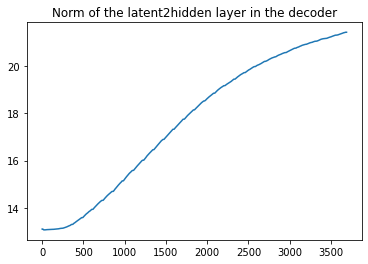

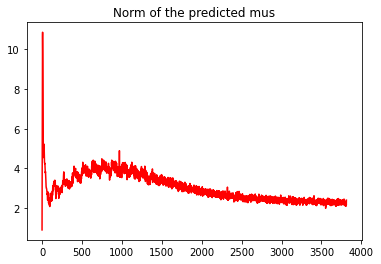

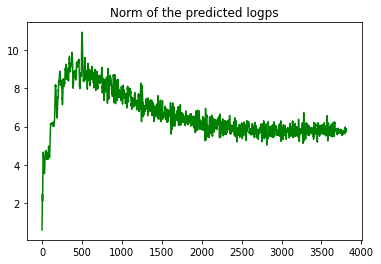

In [19]:
y=Gen.generator.model.decoder.norm
x=np.arange(len(y))

plt.plot(x,y)
plt.title("Norm of the latent2hidden layer in the decoder")
plt.show()

y=Gen.generator.model.encoder.means
x=np.arange(len(y))

plt.plot(x,y, 'r')
plt.title("Norm of the predicted mus")
plt.show()

y=Gen.generator.model.encoder.logps
x=np.arange(len(y))

plt.plot(x,y, 'g')
plt.title("Norm of the predicted logps")
plt.show()

2.2048757937783843


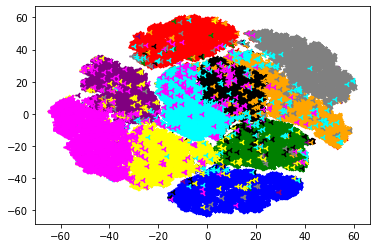

In [9]:
df=pd.read_csv('graph_MNIST.tsv', sep='\t', index_col=0)
ll=list(df['points'])
ll=np.array([literal_eval(l) for l in ll])
# print(ll)
ll=[np.linalg.norm(l) for l in ll]
print(np.mean(ll))

colors=['red', 'blue', 'green',
		'black', 'purple', 'orange',
		'grey', 'yellow', 'cyan',
		'magenta']
for i in range(10):
	dfTemp=df[df['labs']==i]
	x=dfTemp['x']
	y=dfTemp['y']
	plt.scatter(x=x, y=y, c=colors[i] , marker='3')

plt.show()
